### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
# import data handling class
from DT5550 import *

In [2]:
tcorr = np.array([0,10,22,12,32,12,13,9])

In [28]:
def four_gamma():
    if io.valid.sum() == 4:
        esum = 0
        nsum = 0
        tav  = 0
        tlist = []
        for idet in range(N_DETECTOR):
            E = io.Q[idet]
            if io.valid[idet]:
                if (E>1100) and (E<1350):
                    isel = idet
                    tsel = io.t[idet]
                else:
                    esum = esum + io.Q[idet]
                    tlist.append(io.t[idet])
                    nsum = nsum + 1
        
        if nsum==3:
            tlist = np.array(tlist)
            tav = tlist.mean()
            tstd = np.sqrt(tlist.var())
            E1.append(tstd)
            #print(tstd)
            if tstd<100 and tsel<tav and esum>800 and esum<1200:
                E0.append(esum)
                t0.append(tsel)
                t1.append(tav)

                
                
def two_gamma():
    if io.valid.sum() == 2:
        idet_sel = []
        for idet in range(N_DETECTOR):
            #if io.valid[idet] and io.Q[idet]>490 and io.Q[idet]<530:#io.Q[idet]>490 and io.Q[idet]<530 and (idet!=4):
            if io.valid[idet] and (idet!=4):
                idet_sel.append(idet)
                
        idet_sel = np.array(idet_sel)
        
        if idet_sel[0] == 0 and len(idet_sel) == 2:
            id0 = idet_sel[0]
            id1 = idet_sel[1]
            delta_t[id1].append(io.tc[id1]-io.tc[id0])
        
        if len(idet_sel) >= 2:
            E0.append(io.Q[idet_sel[0]])
            E1.append(io.Q[idet_sel[1]])
            t0.append(io.t[idet_sel[0]]+tcorr[idet_sel[0]])
            t1.append(io.t[idet_sel[1]]+tcorr[idet_sel[1]])
            t0c.append(io.tc[idet_sel[0]]+tcorr[idet_sel[0]])
            t1c.append(io.tc[idet_sel[1]]+tcorr[idet_sel[1]])
        

Filename to process

Open a datafile and read the data

In [29]:
#
# open the datfile
#
#io = DT5550(file='../../data/20211213_103444/data_20211213_103444_0.raw')
io = DT5550(indir='C:/data/20211217_171057/')
#io = DT5550(indir='C:/data/20211217_145334/')

#io = DT5550(file='../../DT5550_DAQ/daq/ReadoutClient/test0.raw')


t0 = []
t1 = []
t0c = []
t1c = []
E0 = []
E1 = []
Es = []
nmax = 5
ifile = 0
delta_t = [[] for i in range(N_DETECTOR)]

for file in io.filenames:
    io.open_data(file)
    while io.read_event() == 0:
        if io.n_event%100000 == 0:
            print('Processed ',io.n_event,' events')
        # four gamma analysis    
        #####four_gamma()    
        # timing performance
        two_gamma()
        
        esum = 0
        tsel = []
        for i in range(8):
            if io.valid[i] and i!=4:
                esum = esum + io.Q[i]

        Es.append(esum)
    ifile = ifile +1
    if ifile>nmax:
        break
    
t0 = np.array(t0)
t1 = np.array(t1)
t0c = np.array(t0c)
t1c = np.array(t1c)
E0 = np.array(E0)
E1 = np.array(E1)

Es = np.array(Es)
delta_t = np.array(delta_t, dtype=object)

print('Processing done')

DT5550:: Data recorded with config:  C:/data/20211217_171057\config_20211217_171057.json
DT5550:: Open data file: C:/data/20211217_171057\data_20211217_171057_0.raw
Processed  100000  events
DT5550:: Open data file: C:/data/20211217_171057\data_20211217_171057_1.raw
Processed  200000  events
Processing done


A few basic plots: integrated charge and time

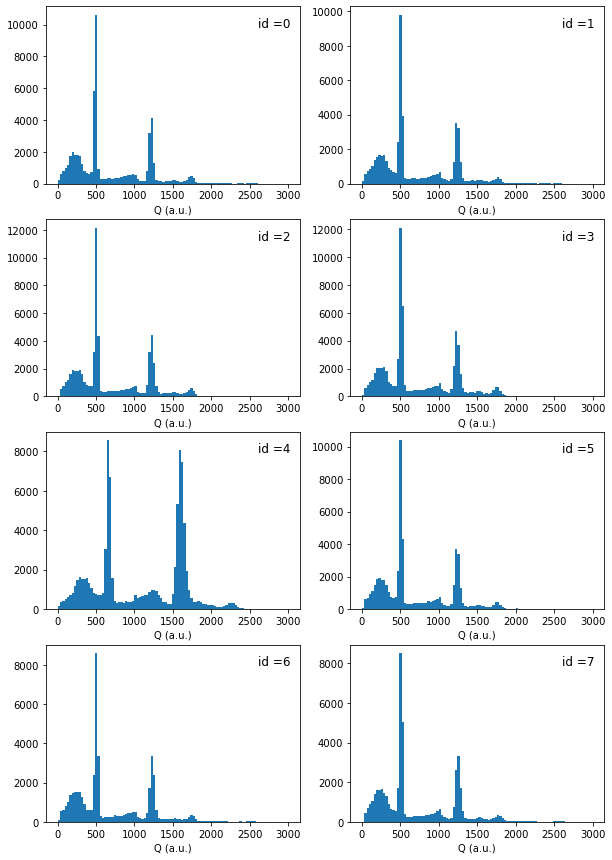

In [30]:
io.plot_all(type="charge",bins=99,logy=False, range=(0,3000))

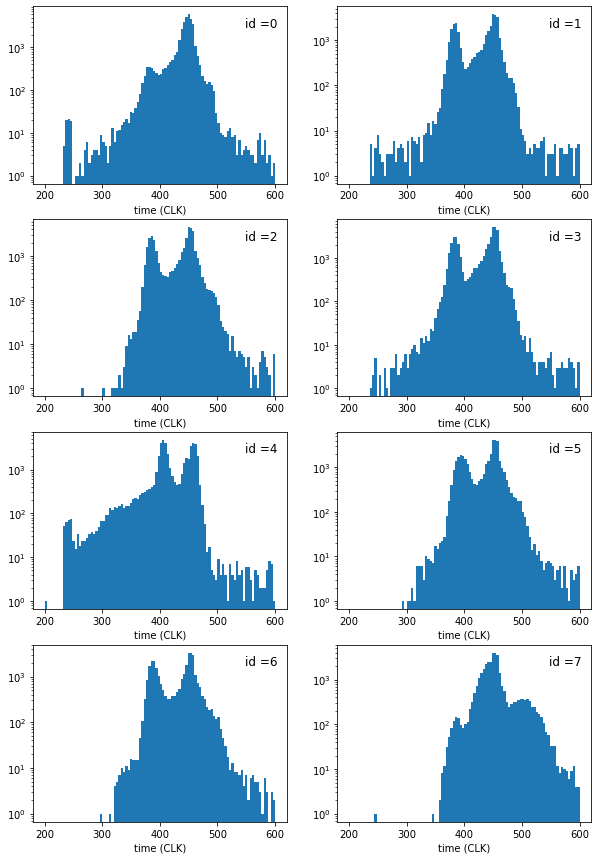

In [93]:
io.plot_all(type="time",range=(200,600),bins=100,logy=True)

99.82629770339787


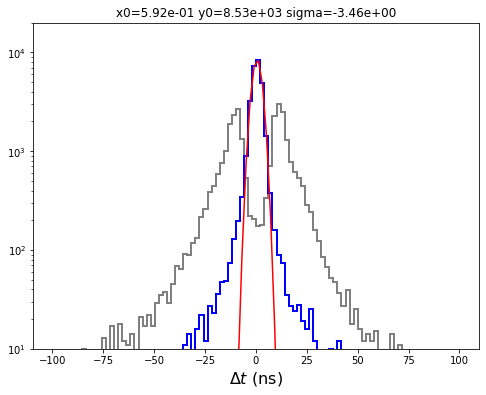

In [31]:
from scipy.optimize import curve_fit

plt.figure(figsize=(8,6))

dt_nocorr = (t0-t1)
dt_nocorr = dt_nocorr[abs(dt_nocorr)<100]

dt = (t0c-t1c)
dt = dt[abs(dt)<100]

bins = 100
y, xe  = np.histogram(dt,bins=bins)
x = .5 * (xe[:-1] + xe[1:])
print(xe[-1])

# Function to be fitted
def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

# Initialization parameters
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=p0)

# Plot the results
plt.title('x0=%.2e y0=%.2e sigma=%.2e' % (fit[0], fit[1], fit[2]))
# Data
plt.hist(dt_nocorr,bins=bins, histtype='step',linewidth=2,color='grey')
plt.hist(dt,bins=bins,histtype='step',linewidth=2,color='blue')

#plt.plot(x, y, drawstyle='steps', color='blue',linewidth=2)
# Fitted function
x_fine = np.linspace(xe[0], xe[-1], 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'r-')

plt.xlabel('$\Delta t$ (ns)',fontsize=16)
plt.yscale('log')
plt.ylim(10,20000)

plt.savefig('Gaussian_fit.png')


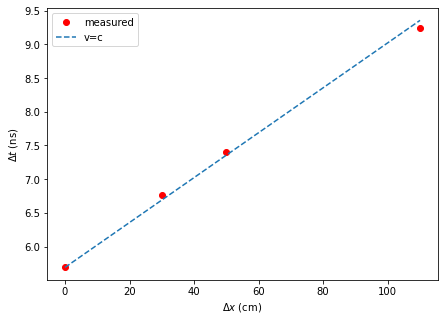

In [11]:
#
# speed of light measurement with Na22 source
#
y0=5.69
plt.figure(figsize=(7,5))
plt.plot([0,30,50,110],[5.69, 6.77, 7.40, 9.24],'o',color='red',label='measured')
plt.plot([0,110],[y0,y0+110/30],'--',label='v=c')
plt.legend()
plt.xlabel('$\Delta x$ (cm)')
plt.ylabel('$\Delta t$ (ns)')
plt.savefig('lightspeed.pdf')

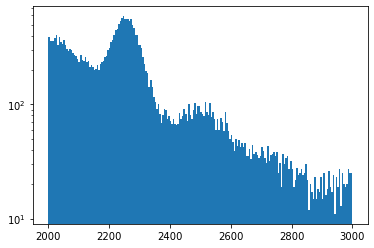

In [32]:
h = plt.hist(Es,bins=200,range=(2000,3000))
plt.yscale('log')